# **Distinctive Image Features from Scale-Invariant Keypoints**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, lstsq, norm
from numpy import float32
import math

from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging

In [ ]:
image = cv2.imread('image.jpeg', 0)
float_tolerance = 0.01

Gaussian Filtering

In [ ]:
def gaussian_filter(img, sigma, k):
    kernel = np.zeros((k,k))
    
    for x in range(-k//2, k//2+1):
        for y in range(-k//2, k//2+1):
            kernel[x+k//2,y+k//2] = np.exp(-(x**2+y**2)/(2*(sigma**2)))/np.sqrt(2*np.pi*(sigma**2)) 
            
    kernel = kernel/np.sum(kernel)
    
    img_padded = np.zeros((img.shape[0]+k-1, img.shape[1]+k-1))
    img_padded[k//2:img_padded.shape[0]-k//2,k//2:img_padded.shape[1]-k//2] = img.copy()
    
    p = np.zeros(img.shape)
    
    for i in range(k//2,img_padded.shape[0]-k//2):
        for j in range(k//2,img_padded.shape[1]-k//2):
            p[i-k//2][j-k//2] = np.sum(img_padded[i-k//2:i+k//2+1, j-k//2:j+k//2+1] * kernel)
            
    return p

Generating Base Image

In [ ]:
def generateBaseImage(image, sigma, initial_blur):
    #double the size of the original image to get base image
    image = cv2.resize(image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    #Compute difference of sigma depending upon the initial blur and the required blur
    sigma_diff = np.sqrt(max((sigma ** 2) - ((2 * initial_blur) ** 2), 0.01))
    #Apply the gaussian blur
    return cv2.GaussianBlur(image, (0,0), sigmaX=sigma_diff, sigmaY=sigma_diff)

Compute Number of Octaves

In [ ]:
def computeNumberOfOctaves(n):
    #compute number of octaves
    return int(np.round(np.log(np.min(n))/np.log(2) - 1))

In [ ]:
def generateGaussianKernels(sigma, s):
    num_images_per_octave = s + 3
    k = 2**(1/s)
    #scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels = np.zeros(num_images_per_octave)
    gaussian_kernels[0] = sigma
    #store the sigma values for the image pyramid
    for idx in range(1, num_images_per_octave):
        sigma_previous = (k ** (idx - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[idx] = np.sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

In [ ]:
def generateGaussianImages(image, num_octaves, gaussian_kernels):
    gaussian_images = []
    #for each octave compute the gaussian blurred images
    for _ in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = cv2.GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST) #resize image depending upon the octave size
    return np.array(gaussian_images)

In [ ]:
def generateDoGImages(gaussian_images):
    dog_images = []
    #Compute the difference of consecutive gaussian images
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for i in range(gaussian_images_in_octave.shape[0]-1):
            first_image = gaussian_images_in_octave[i]
            second_image = gaussian_images_in_octave[i+1]
            dog_images_in_octave.append(cv2.subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return np.array(dog_images)

## Finding Scale Space Extrema

In [ ]:
# Finding the points that are invariant to scale change
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    keypoints = []
    threshold = np.floor(0.5*contrast_threshold/num_intervals*255)

    for octave_index, dog_images_in_octave in enumerate(dog_images):
       # Take 3 adjacent images D(x, y, σ) for finding extrema
        for image_index, (img1,img2,img3) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            for i in range(image_border_width, img1.shape[0]-image_border_width):
                for j in range(image_border_width, img1.shape[1]-image_border_width):
                    #(i,j) of the first image is taken as the center pixel of 3*3 kernel.
                    if isPixelAnExtremum(img1[i-1:i+2, j-1:j+2],img2[i-1:i+2, j-1:j+2],img3[i-1:i+2, j-1:j+2],threshold):
                        # find the localization extrema
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            # if the localization extrema exist add to the keypoints
                            keypoint,index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint,octave_index,gaussian_images[octave_index][index])
                            for p in keypoints_with_orientations:
                                keypoints.append(p)
    return keypoints

In [ ]:
# Finding the local minima/maxima of D(x, y, σ)
# Compare each sample point to 8 neighbours in current image and 9 above and below
# Include the point if its smaller than all of them or larger than all of them
def isPixelAnExtremum(sub_img1, sub_img2, sub_img3, threshold):
  center_pixel = sub_img2[1,1]
  if abs(center_pixel)<=threshold:
    return False
  truth_value = False
  #if pixel value is negative its value must be smaller than all neighbouring values
  if center_pixel <0:
    truth_value = np.all(center_pixel <= sub_img1) and np.all(center_pixel <= sub_img3) and np.all(center_pixel <= sub_img2[0, :]) and np.all(center_pixel <= sub_img2[2, :]) and center_pixel <= sub_img2[1, 0] and center_pixel <= sub_img2[1, 2]
  #if pixel value is positive its value must be larger than all neighbouring values
  if center_pixel >0:
    truth_value = np.all(center_pixel >= sub_img1) and np.all(center_pixel >= sub_img3) and np.all(center_pixel >= sub_img2[0, :]) and np.all(center_pixel >= sub_img2[2, :]) and center_pixel >= sub_img2[1, 0] and center_pixel >= sub_img2[1, 2]
  return truth_value

## Localizing Extrema

In [ ]:
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    #Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = np.stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * np.dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = np.trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = cv2.KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None


In [ ]:
def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])

In [ ]:
def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

In [ ]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = np.zeros(num_bins)
    smooth_histogram = np.zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                    gradient_orientation = np.rad2deg(np.arctan2(dy, dx))
                    weight = np.exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = np.max(smooth_histogram)
    orientation_peaks = np.where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [ ]:

def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

In [ ]:
def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    descriptors = []

    for keypoint in keypoints:
        #computing octave,layer,scale for keypoint
        octave = keypoint.octave&255
        octave = np.where(octave>=128,octave|-128,octave)
        layer = (keypoint.octave >> 8) & 255
        scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
        
        pixel = round(scale * array(keypoint.pt)).astype('int')

        gaussian_image = gaussian_images[octave + 1, layer]
        gauss_rows, gauss_cols = gaussian_image.shape
        
        
        bins_degree = num_bins / 360.

        cost = cos(deg2rad(360. - keypoint.angle))
        sint = sin(deg2rad(360. - keypoint.angle))
        
        
        weight_factor = -0.5 / ((0.5 * window_width) ** 2)
        # initializing histogram bins values,magnitude and orientation for each pixel
        hist_tensor = np.zeros((window_width+2,window_width+2,num_bins))
        hist_width = 0.5*scale_multiplier*scale*keypoint.size
        half_width = int(min(int(round(hist_width * np.sqrt(2) * (window_width + 1) * 0.5)), np.sqrt(gauss_rows ** 2 + gauss_cols ** 2)))    
        row_bin = []
        col_bin = []
        magnitude_bin = []
        orientation_bin = []

        #calculating histogram bins values,magnitude and orientation for each pixel
        for r in range(-half_width,half_width+1):
          for c in range(-half_width,half_width+1):
            row_b = ((c*sint+r*cost)/hist_width)+(window_width/2)-0.5   #(c*sint+r*cost) are the rotated coordinates
            col_b = ((c*cost-r*sint)/hist_width)+(window_width/2)-0.5   #(c*cost-r*sint) are the rotated coordinates
            flag1 = (row_b>-1)&(row_b<window_width)&(col_b>-1)&(col_b<window_width)
            if flag1==1:
              row_w  = int(round(pixel[1]+r))
              col_w =  int(round(pixel[0]+c))
              flag2 = (row_w>0)&(row_w<gauss_rows-1)&(col_w>0)&(col_w<gauss_cols-1)
              if flag2 == 1:
                #calculate gradients
                dx = gaussian_image[row_w,col_w+1]-gaussian_image[row_w,col_w-1]
                dy = gaussian_image[row_w-1,col_w]-gaussian_image[row_w+1,col_w]
                w = np.exp(weight_factor*(((c*sint+r*cost)/hist_width)** 2+((c*cost-r*sint)/hist_width)** 2))
                row_bin.append(row_b)
                col_bin.append(col_b)
                magnitude_bin.append(w*(np.sqrt(dx**2+dy**2)))
                orientation_bin.append((np.rad2deg(np.arctan2(dy,dx))%360-(360. - keypoint.angle)) * bins_degree)

        #smoothing using trilinear interpolation inverse: take centre value of cube and distribute to 8 neighbours
        for row_b, row_c, magnitude, orientation in zip(row_bin,col_bin,magnitude_bin,orientation_bin):
            #take floor of values
            row_b_floor = floor(row_b).astype(int)
            col_b_floor = floor(row_c).astype(int)
            orientation_b_floor = floor(orientation).astype(int)
            row_fraction = row_b-row_b_floor
            col_fraction = row_c-col_b_floor
            orientation_fraction = orientation-orientation_b_floor
            # check range
            orientation_b_floor = np.where(orientation_b_floor<0,orientation_b_floor+num_bins,orientation_b_floor)
            orientation_b_floor = np.where(orientation_b_floor>=num_bins,orientation_b_floor-num_bins,orientation_b_floor)

            #applying trilinear interpolation inverse
            w1, w0 = (magnitude*row_fraction,magnitude * (1-row_fraction))
            w11,w10,w01,w00 = (w1*col_fraction,w1*(1-col_fraction),w0*col_fraction,w0*(1-col_fraction))
            w111,w110,w101,w100,w011,w010,w001,w000=(w11*orientation_fraction,w11*(1-orientation_fraction),w10*orientation_fraction,w10*(1-orientation_fraction),w01*orientation_fraction,w01*(1-orientation_fraction),w00*orientation_fraction,w00*(1-orientation_fraction))
            #smoothing
            i,j,k,l = (row_b_floor+1,col_b_floor+1,orientation_b_floor,(orientation_b_floor+1)%num_bins)
            hist_tensor[row_b_floor+1,col_b_floor+1,orientation_b_floor]+=w000
            hist_tensor[i,j,l]+=w001
            hist_tensor[i,j+1,k]+=w010
            hist_tensor[i,j+1,l]+=w011
            hist_tensor[i+1,j,k]+=w100
            hist_tensor[i+1,j,l]+=w101
            hist_tensor[i+1,j+1,k]+=w110
            hist_tensor[i+1,j+1,l]+=w111


        #remove borders, flatten
        descriptor_v = hist_tensor[1:-1,1:-1,:].flatten() 
        #normalize and threshold
        threshold = norm(descriptor_v)*descriptor_max_value
        descriptor_v = np.where(descriptor_v>threshold,threshold,descriptor_v)
        descriptor_v /= max(norm(descriptor_v), float_tolerance)
        descriptor_v = round(512 * descriptor_v)
        descriptor_v = np.where(descriptor_v<0,0,descriptor_v)
        descriptors.append(descriptor_v)
    return array(descriptors, dtype='float32')

In [ ]:
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    image = image.astype('float32')
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    print(keypoints)
    keypoints = removeDuplicateKeypoints(keypoints)
    print(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    print(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

In [ ]:
img = cv2.imread('box.png')
img_gray = cv2.imread('box.png',0)
imp_copy = cv2.imread('box.png')
k, d = computeKeypointsAndDescriptors(img_gray)
print(k, d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


[<KeyPoint 0x7f9289769de0>, <KeyPoint 0x7f928807ad80>, <KeyPoint 0x7f928807aea0>, <KeyPoint 0x7f928807a9c0>, <KeyPoint 0x7f927bc4e990>, <KeyPoint 0x7f928807ac90>, <KeyPoint 0x7f927bc4e090>, <KeyPoint 0x7f927bc4e420>, <KeyPoint 0x7f927bc4ef90>, <KeyPoint 0x7f927bc4e330>, <KeyPoint 0x7f927bc4edb0>, <KeyPoint 0x7f927bc4e060>, <KeyPoint 0x7f927bc4e240>, <KeyPoint 0x7f927bc4e7e0>, <KeyPoint 0x7f927bc4e180>, <KeyPoint 0x7f927bc4e630>, <KeyPoint 0x7f927bc4ef30>, <KeyPoint 0x7f927bc4eba0>, <KeyPoint 0x7f927bc4e2d0>, <KeyPoint 0x7f927bc4e4e0>, <KeyPoint 0x7f927bc4e690>, <KeyPoint 0x7f927bc4e270>, <KeyPoint 0x7f927bc4e570>, <KeyPoint 0x7f927bc4eb40>, <KeyPoint 0x7f927bc4ecc0>, <KeyPoint 0x7f927bc4ebd0>, <KeyPoint 0x7f927bc4e2a0>, <KeyPoint 0x7f927bc4eb70>, <KeyPoint 0x7f927bc4ef00>, <KeyPoint 0x7f927bc4ed80>, <KeyPoint 0x7f927bc4ee70>, <KeyPoint 0x7f927bc4eab0>, <KeyPoint 0x7f927bc4ec90>, <KeyPoint 0x7f927bc4e9c0>, <KeyPoint 0x7f927bc4e0f0>, <KeyPoint 0x7f927bc4e3f0>, <KeyPoint 0x7f927bc4e9f0>, 

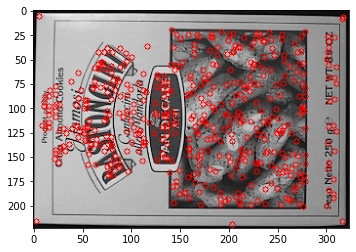

In [ ]:
imp_copy = img.copy()
for m in k:
  res = cv2.circle(imp_copy, (int(m.pt[0]),int(m.pt[1])), 3, (255,0,0))

plt.figure()
plt.imshow(res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


[<KeyPoint 0x7f927b625210>, <KeyPoint 0x7f927b6252a0>, <KeyPoint 0x7f927b625570>, <KeyPoint 0x7f927b6255a0>, <KeyPoint 0x7f927b6254e0>, <KeyPoint 0x7f927b625600>, <KeyPoint 0x7f927b625630>, <KeyPoint 0x7f927b625660>, <KeyPoint 0x7f927b625690>, <KeyPoint 0x7f927b6256f0>, <KeyPoint 0x7f927bb557e0>, <KeyPoint 0x7f927bb853c0>, <KeyPoint 0x7f927b6254b0>, <KeyPoint 0x7f927b625780>, <KeyPoint 0x7f927b6257b0>, <KeyPoint 0x7f927b6257e0>, <KeyPoint 0x7f927b625270>, <KeyPoint 0x7f927b625810>, <KeyPoint 0x7f927b625990>, <KeyPoint 0x7f927b625540>, <KeyPoint 0x7f927b625a20>, <KeyPoint 0x7f927b625720>, <KeyPoint 0x7f927b625a80>, <KeyPoint 0x7f927b625ab0>, <KeyPoint 0x7f927b625ae0>, <KeyPoint 0x7f927b6255d0>, <KeyPoint 0x7f927b625b70>, <KeyPoint 0x7f927b625240>, <KeyPoint 0x7f927b625ba0>, <KeyPoint 0x7f927b6258a0>, <KeyPoint 0x7f927b625bd0>, <KeyPoint 0x7f927b625c00>, <KeyPoint 0x7f927b625c30>, <KeyPoint 0x7f927b6259c0>, <KeyPoint 0x7f927b6256c0>, <KeyPoint 0x7f927b625cc0>, <KeyPoint 0x7f927b625510>, 

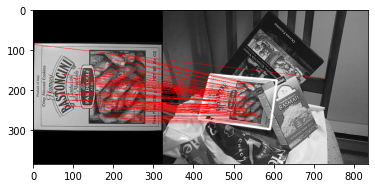

In [ ]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('box.png', 0)           # queryImage
img2 = cv2.imread('box_in_scene.png', 0)  # trainImage

# Compute SIFT keypoints and descriptors
kp1, des1 = computeKeypointsAndDescriptors(img1)
kp2, des2 = computeKeypointsAndDescriptors(img2)

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (255, 0, 0))

    plt.imshow(newimg)
    plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


[<KeyPoint 0x7f9279df9510>, <KeyPoint 0x7f9279df9c90>, <KeyPoint 0x7f9279df98d0>, <KeyPoint 0x7f9279df9a20>, <KeyPoint 0x7f927b640f00>, <KeyPoint 0x7f927b640fc0>, <KeyPoint 0x7f9279df97e0>, <KeyPoint 0x7f9279df9960>, <KeyPoint 0x7f9279df9300>, <KeyPoint 0x7f927b626f30>, <KeyPoint 0x7f9279df9bd0>, <KeyPoint 0x7f9279df99f0>, <KeyPoint 0x7f9279df9a80>, <KeyPoint 0x7f9279df9120>, <KeyPoint 0x7f9279df9db0>, <KeyPoint 0x7f9279df96c0>, <KeyPoint 0x7f9279df9ba0>, <KeyPoint 0x7f9279df9390>, <KeyPoint 0x7f9279df9de0>, <KeyPoint 0x7f9279df9150>, <KeyPoint 0x7f9279df9870>, <KeyPoint 0x7f9279df9630>, <KeyPoint 0x7f9279df9f00>, <KeyPoint 0x7f9279df9990>, <KeyPoint 0x7f9279df9330>, <KeyPoint 0x7f9279df9ae0>, <KeyPoint 0x7f9279df9b70>, <KeyPoint 0x7f9279df90c0>, <KeyPoint 0x7f9279df9420>, <KeyPoint 0x7f9279df94e0>, <KeyPoint 0x7f9279df9b10>, <KeyPoint 0x7f9279df95d0>, <KeyPoint 0x7f9279df9450>, <KeyPoint 0x7f9279df9fc0>, <KeyPoint 0x7f9279df93c0>, <KeyPoint 0x7f9279df97b0>, <KeyPoint 0x7f9279df9480>, 

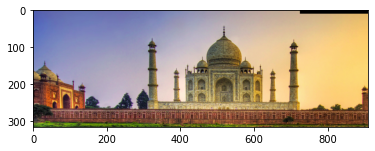

In [ ]:
img4 = cv2.imread('taj2.png')
img5 = cv2.imread('taj1.png')

image1_gray=cv2.cvtColor(img4,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(img5,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(img4,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(img5,cv2.COLOR_BGR2RGB)

kp1, des1 = computeKeypointsAndDescriptors(image1_gray)
kp2, des2 = computeKeypointsAndDescriptors(image2_gray)


match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.03*n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)

dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1]//4, image2.shape[0]))
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)

In [ ]:
import time

In [ ]:
  img = cv2.imread('box.png')
  gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  h,w = gray.shape

  time_arr_sift = []
  time_arr_orb = []
  time_arr_surf = []

  for k in range(1,11):
    print(k)
    temp = cv2.resize(gray,(k*w,k*h))

    t0 = time.time()
    sift = cv2.SIFT_create()
    kp = sift.detect(temp, None)
    temp=cv2.drawKeypoints(gray,kp,temp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    t1 = time.time()

    time_arr_sift.append(t1-t0)

    temp = cv2.resize(gray,(k*w,k*h))

    t0 = time.time()
    orb = cv2.xfeatures2D.ORB_create() 
    kp = orb.detect(temp, None)
    temp=cv2.drawKeypoints(gray,kp,temp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    t1 = time.time()

    time_arr_orb.append(t1-t0)

    temp = cv2.resize(gray,(k*w,k*h))

    t0 = time.time()
    surf = cv2.xfeatures2D.SURF_create() 
    kp = surf.detect(temp, None)
    temp=cv2.drawKeypoints(gray,kp,temp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    t1 = time.time()

    time_arr_surf.append(t1-t0)

In [ ]:
!pip3 install opencv-python